This notebook fits the deflector light profile of WGD 2038-4008 from a large cutout using isophote-based elliptical model.

### imports

In [1]:
import numpy as np
import os
import h5py
import joblib

import lenstronomy.Util.util as util
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Plots import chain_plot
from lenstronomy.Sampling.parameters import Param
#from lenstronomy.Analysis.lens_analysis import LensAnalysis
from lenstronomy.Util import mask_util
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Util.util import array2image


from lenstronomy.Util import param_util

cwd = os.getcwd()
base_path, _ = os.path.split(cwd)
print('Base directory path:', base_path)

Base directory path: /Users/ajshajib/Research/time_delay_cosmography/J2038/WGD2038-4008/lenstronomy_modeling


### plot settings

In [2]:
import matplotlib as mpl
import paperfig as pf

msh_cmap = pf.msh_cmap
msh_cmap2 = pf.msh_cmap2

pf.set_fontscale(2.)

### functions

In [3]:
from photutils import detect_threshold
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from photutils import detect_sources
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils import deblend_sources
import numpy as np
import astropy.units as u
from photutils import source_properties, EllipticalAperture
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize


def get_mask(large_image, bkg_rms):
    """
    Create a mask covering the nearby stars/galaxies.
    """
    #threshold = detect_threshold(data, nsigma=2.)

    threshold = (3.0 * bkg_rms)  

    sigma = 6.0 * gaussian_fwhm_to_sigma  # FWHM = 3.
    kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
    kernel.normalize()
    segm = detect_sources(large_image, threshold, npixels=5, filter_kernel=kernel)


    norm = ImageNormalize(stretch=SqrtStretch())
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
    ax1.imshow(large_image, origin='lower', cmap='Greys_r', norm=norm)
    ax1.set_title('Data')
    cmap = segm.make_cmap(random_state=12345)
    ax2.imshow(segm, origin='lower', cmap=cmap)
    ax2.set_title('Segmentation Image')


    segm_deblend = deblend_sources(large_image, segm, npixels=9,
                                   filter_kernel=kernel, nlevels=32,
                                   contrast=0.01)


    cat = source_properties(large_image, segm_deblend)
    r = 3.  # approximate isophotal extent
    apertures = []
    for obj in cat:
        position = np.transpose((obj.xcentroid.value, obj.ycentroid.value))
        a = obj.semimajor_axis_sigma.value * r
        b = obj.semiminor_axis_sigma.value * r
        theta = obj.orientation.to(u.rad).value
        apertures.append(EllipticalAperture(position, a, b, theta=theta))


    norm = ImageNormalize(stretch=SqrtStretch())
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
    ax1.imshow(large_image, origin='lower', cmap='Greys_r', norm=norm)
    ax1.set_title('Data')
    cmap = segm_deblend.make_cmap(random_state=12345)
    ax2.imshow(segm_deblend, origin='lower', cmap=cmap)
    ax2.set_title('Segmentation Image')
    for aperture in apertures:
        aperture.plot(axes=ax1, color='white', lw=1.5)
        aperture.plot(axes=ax2, color='white', lw=1.5)

    a = np.array(segm_deblend)

    s = set(a.flatten())
    area = []

    for num in s:
        if num == 0:
            continue
        counter = np.zeros_like(a)
        counter[a == num] = 1
        area.append(np.sum(counter))

    central_id = list(s)[np.argmax(area)]+1

    a[a == central_id] = 0

    plt.matshow(a, origin='lower')
    plt.title('initial segmented mask')
    plt.show()

    kernel = np.ones((11, 11),np.uint8)

    dilation = cv2.dilate(a.astype(np.uint8), kernel, iterations=1)

    plt.matshow(dilation, origin='lower')
    plt.title('dilated mask')
    plt.show()
    
    large_mask = np.zeros_like(dilation)
    large_mask[dilation == 0] = 1

    plt.matshow(np.log10(large_image*large_mask), origin='lower')
    plt.show()
    
    return large_mask

# Fit profiles

In [4]:
import warnings
warnings.filterwarnings('ignore')
import cv2
import copy
import h5py

import paperfig as pf
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import coloripy as cp

import lenstronomy.Util.class_creator as class_creator
from lenstronomy.ImSim.MultiBand.single_band_multi_model import SingleBandMultiModel

### load a model run to subtract the lensed arcs and QSO images from the deflector 

In [5]:
job_name_out = '2038_run143_0_1_2_0_0_shortened'

input_temp = os.path.join(base_path, 'temp', job_name_out +'.txt')
output_temp = os.path.join(base_path, 'temp', job_name_out +'_out.txt')

f = open(output_temp, 'rb')
[input_, output_] = joblib.load(f)
f.close()

fitting_kwargs_list, kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, init_samples = input_

kwargs_result, multi_band_list_out, fit_output, _ = output_

band_index = 0

kwargs_data, kwargs_psf, _ = multi_band_list_out[band_index]

samples_mcmc = np.array(fit_output[-1][1])
medians = np.median(samples_mcmc, axis=0)

# walker_ratio = 8

# mcmc_repeat = 1

# samples_mcmc = np.array(fit_output[-1][1])

# print('Shape of MCMC chain:', samples_mcmc.shape)

# n_params = samples_mcmc.shape[1]

# n_walkers = 8 * n_params
# n_step = int(samples_mcmc.shape[0] / n_walkers)

# print('n_step: {}, n_walkers: {}, n_params: {}'.format(n_step, n_walkers, n_params))

# chain = np.empty((n_walkers, n_step, n_params))


# for i in np.arange(n_params):
#     samples = samples_mcmc[:, i].T
#     chain[:,:,i] = samples.reshape((n_step, n_walkers)).T


# mean_pos = np.zeros((n_params, n_step))
# median_pos = np.zeros((n_params, n_step))
# std_pos = np.zeros((n_params, n_step))
# q16_pos = np.zeros((n_params, n_step))
# q84_pos = np.zeros((n_params, n_step))

# for i in np.arange(n_params):
#     for j in np.arange(n_step):
#         mean_pos[i][j] = np.mean(chain[:, j, i])
#         median_pos[i][j] = np.median(chain[:, j, i])
#         std_pos[i][j] = np.std(chain[:, j, i])
#         q16_pos[i][j] = np.percentile(chain[:, j, i], 16.)
#         q84_pos[i][j] = np.percentile(chain[:, j, i], 84.)
        
# burnin = -1
# last = n_step

# medians = []

# for i in range(n_params):
#     medians.append(np.median(median_pos[i][burnin:last]))

param_class = Param(kwargs_model,
                kwargs_params['lens_model'][2], 
                kwargs_params['source_model'][2],
                kwargs_params['lens_light_model'][2],
                kwargs_params['point_source_model'][2],
                kwargs_lens_init=kwargs_params['lens_model'][0], 
                **kwargs_constraints
               )

kwargs_median = param_class.args2kwargs(medians)

**Here, we subtract the lensed arcs and the quasar images from the large cutout image.**

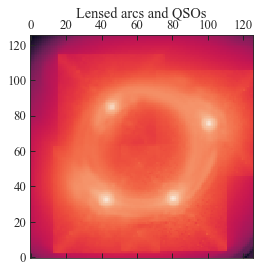

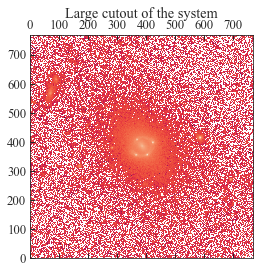

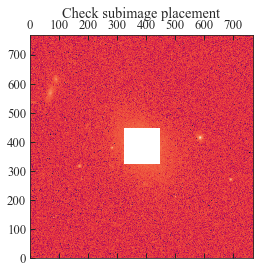

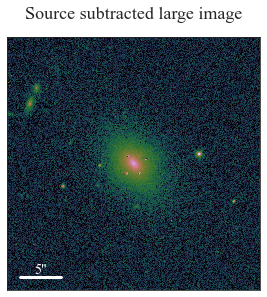

In [6]:
from rgb_functions import *

mask_list = kwargs_likelihood['image_likelihood_mask_list']
band_bool = [True] * 3
band_bool[band_index] = True

pf.set_fontscale(1.6)
fontsize = pf.mnras_figcaption_fontsize*1.6



image_model = class_creator.create_im_sim(multi_band_list_out, kwargs_data_joint['multi_band_type'], 
                                          kwargs_model,
                                          bands_compute=band_bool,
                                          likelihood_mask_list=mask_list)

model, error_map, cov_param, param = image_model.image_linear_solve(inv_bool=True, **kwargs_median)
    

band_model = SingleBandMultiModel(multi_band_list_out, kwargs_model, likelihood_mask_list=mask_list,
                                  band_index=band_index)

kwargs_lens_partial, kwargs_source_partial, kwargs_lens_light_partial, kwargs_ps_partial, _kwargs_extinction_partial = band_model.select_kwargs(**kwargs_median)
_kwargs_lens_partial, _kwargs_source_partial, _kwargs_lens_light_partial, _kwargs_ps_partial = band_model.update_linear_kwargs(param[band_index], kwargs_lens_partial, kwargs_source_partial, kwargs_lens_light_partial, kwargs_ps_partial)


data = kwargs_data['image_data']

lensed_arcs = band_model.image(_kwargs_lens_partial, _kwargs_source_partial, _kwargs_lens_light_partial,
                                          _kwargs_ps_partial, unconvolved=False, source_add=True,
                                          lens_light_add=False, point_source_add=True)

lensed_source = lensed_arcs #data - lensed_arcs

plt.matshow(np.log10(lensed_arcs), origin='lower')
plt.title('Lensed arcs and QSOs')
plt.show()

if band_index == 0:
    filt = 'F814W'
    data_filename = '../data/data_f814w_large_cutout.hdf5'
elif band_index == 1:
    filt = 'F475X'
    data_filename = '../data/data_f475x_large_cutout.hdf5'

    
local_data_filename = data_filename #os.path.join(base_path, 'data', data_filename)
f = h5py.File(local_data_filename, "r")

large_image_backup = f['image_data'][()]
bkg_rms = f['background_rms'][()]
wht_map = f['exposure_map'][()]
ra_at_xy_0 = f['ra_at_xy_0'][()]
dec_at_xy_0 = f['dec_at_xy_0'][()]
Matrix_inv = f['transform_pix2angle'][()]
f.close()

kwargs_data_large = {'image_data': large_image_backup, 
               'background_rms': bkg_rms,
               'noise_map': None,
               'exposure_time': wht_map,
               'ra_at_xy_0': ra_at_xy_0,
               'dec_at_xy_0': dec_at_xy_0, 
               'transform_pix2angle': Matrix_inv
               }

plt.matshow(np.log10(large_image_backup), origin='lower')
plt.title('Large cutout of the system')
plt.show()

result = cv2.matchTemplate(data.astype(np.float32), large_image_backup.astype(np.float32), cv2.TM_CCOEFF_NORMED)
match = np.unravel_index(result.argmax(),result.shape)

large_image = copy.deepcopy(large_image_backup)
large_image[match[0]:match[0]+len(lensed_source), match[1]:match[1]+len(lensed_source)] -= data

plt.matshow(np.log10(np.abs(large_image)), origin='lower')
plt.title('Check subimage placement')
plt.show()

large_image = copy.deepcopy(large_image_backup)
large_image[match[0]:match[0]+len(lensed_source), match[1]:match[1]+len(lensed_source)] -= lensed_source*mask_list[band_index]

fig = plt.figure(figsize=pf.get_fig_size(width=2*pf.mnras_textwidth/3., height_ratio=1.))
ax = fig.add_subplot(111)
ax.matshow(np.log10(np.abs(large_image)), origin='lower', cmap=pf.cmap, 
           vmax=np.log10(np.abs(large_image)).max(), vmin=-3.)
ax.set_title('Source subtracted large image', fontdict={'fontsize': pf.mnras_text_fontsize*2})

add_scale_bar(ax, length=5, fontsize=14, scale_text=None);
    
ax.set_xticks([])
ax.set_yticks([])
# plt.savefig('/Users/ajshajib/Dropbox/Papers_Proposals/2038_model/figures/source_subtracted_large_cutout.pdf', 
#             bbox_inches='tight')
plt.show()

#large_mask = get_mask(large_image, bkg_rms)

#import numpy.ma as ma

#masked_data = ma.masked_array(large_image, 1-large_mas#

## Fit isophotes using `photutils`

In [7]:
from photutils.isophote import Ellipse, EllipseGeometry
from photutils.isophote import build_ellipse_model

**First fit the isophotes in the inner region.**

In [29]:
g = EllipseGeometry(242.+96*1.5, 240+96*1.5, 60., 0.3, 120./180.*np.pi)
g.find_center(large_image)

ellipse = Ellipse(large_image, geometry=g)
if band_index == 0:
    isolist = ellipse.fit_image(integrmode='median', sclip=3.0, nclip=3, fflag=0.7, maxsma=480.)
elif band_index == 1:
    isolist = ellipse.fit_image(integrmode='median', sclip=3.0, nclip=3, fflag=0.7, maxsma=240.)

INFO: Found center at x0 = 385.0, y0 = 384.0 [photutils.isophote.geometry]


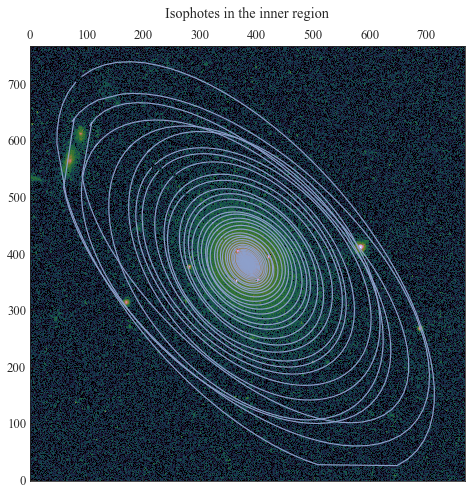

In [30]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(np.log10(np.abs(large_image)), origin='lower', cmap=pf.cmap, 
           vmax=np.log10(np.abs(large_image)).max(), vmin=-3.)
ax.set_title("Isophotes in the inner region")
#ax.set_xlim([300, 900])
#ax.set_ylim([700, 1200])

# go to the outermost successfully fitted ellipse at sma=235
isos = []
for sma in isolist.to_table()['sma']:
    iso = isolist.get_closest(sma)
    isos.append(iso)
    x, y, = iso.sampled_coordinates()
    plt.plot(x, y, color=pf.cb2_blue)



In [31]:
isolist.to_table()

sma,intens,intens_err,ellipticity,ellipticity_err,pa,pa_err,grad,grad_err,grad_rerr,x0,x0_err,y0,y0_err,ndata,flag,niter,stop_code
,,,,,deg,deg,,,,,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,object,object,float64,float64,float64,float64,int64,int64,int64,int64
0.0,1.8309988078533632,0.0,0.0,0.0,0.0,0.0,0.0,None,None,384.1335455437584,0.0,383.91417789528384,0.0,1,0,0,0
0.5111130767700377,1.7778118351747436,0.00202848602674637,0.12833645967776475,0.0253568624615557,139.95768818331854,6.458614708101496,-0.14659658094919636,0.06017363171877709,0.41047090818325777,384.1335455437584,0.0072273125404285895,383.91417789528384,0.007133870835399456,13,0,13,0
0.5622243844470415,1.770788110309245,0.0019602740665835136,0.13532260466785018,0.022369674146164285,143.09673078911322,5.424102143398069,-0.14499644004537335,0.053371237462666955,0.3680865367864593,384.152266724048,0.007080080089637874,383.9027909888335,0.00691707212260788,13,0,14,0
0.6184468228917457,1.7641947524186024,0.002056689057471044,0.1508546811643791,0.02144901224391488,142.4685117162365,4.704328145161982,-0.14184498189149503,0.05089508671698392,0.3588078058053288,384.17147087856756,0.007552158435562145,383.8880383474441,0.007356512453534063,13,0,50,2
0.6802915051809203,1.7572885638724502,0.0021163680177406488,0.1684707739009664,0.02013900274381807,142.4685117162365,3.993071373858821,-0.1384011128077034,0.047713104807753405,0.34474509517887125,384.19398379117456,0.007911201652988805,383.8707439163884,0.007665523643404913,13,0,10,0
0.7483206556990124,1.7502338715850112,0.002164827793417054,0.18871600612510686,0.018812319238074294,142.3227389662057,3.366144122167343,-0.1345002946289359,0.044543115294100204,0.33117485293981924,384.21979213221385,0.008264396072631965,383.8508133196438,0.007963669459560884,13,0,10,0
0.8231527212689137,1.7429238638839555,0.002164661779244501,0.21066914059418598,0.016369010852751456,141.13301686959434,2.6570453609772584,-0.13664769821479752,0.04223793191490189,0.30910093961852014,384.24586115197116,0.00803883331710913,383.8265061157512,0.007748572573141703,13,0,10,0
0.9054679933958051,1.7337352392465932,0.0022624875753936595,0.22570890486563186,0.014058653037722633,136.91565355477277,2.1623290053998003,-0.14740903758554755,0.03967757090428714,0.26916647414688266,384.2585236677926,0.007639961859123642,383.7982545455917,0.0075432553836627895,13,0,10,0


Check the intensity along the isophotes. For a good fit the same colored dots should follow horizontal lines.

Text(0, 0.5, 'Intensity')

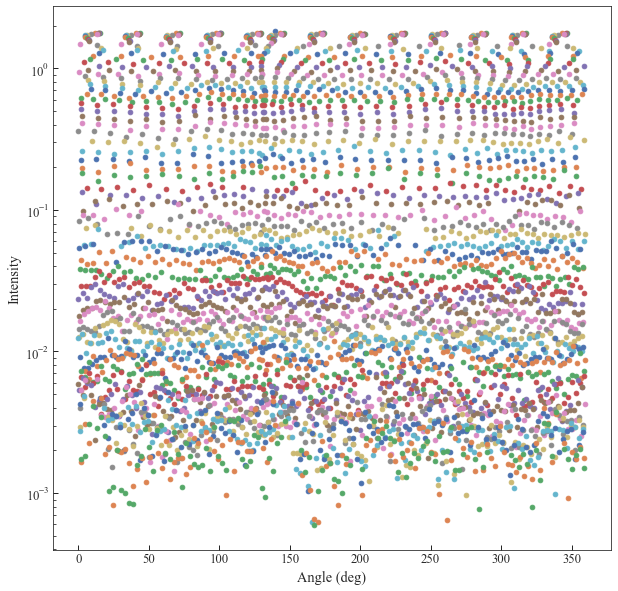

In [32]:
plt.figure(figsize=(10, 10))

for iso in isos:
    angles = ((iso.sample.values[0] + iso.sample.geometry.pa) / np.pi*180.) % 360.
    plt.scatter(angles, iso.sample.values[2])
    
plt.yscale('log')
plt.xlabel("Angle (deg)")
plt.ylabel("Intensity")

Plot the isophote-based model for the inner region.

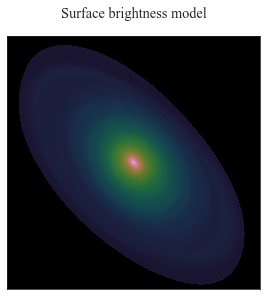

In [33]:
model_image = build_ellipse_model(large_image.shape, isolist)

fig, ax = plt.subplots(figsize=pf.get_fig_size(width=2*pf.mnras_textwidth/3., height_ratio=1.))

ax.matshow(np.log10(model_image+1e-3), origin='lower', cmap=pf.cmap, 
           vmax=np.log10(np.abs(large_image)).max(), vmin=-3.)

ax.set_title('Surface brightness model')

ax.set_xticks([])
ax.set_yticks([])

# plt.savefig('/Users/ajshajib/Dropbox/Papers_Proposals/2038_model/figures/large_coutout_model.pdf', 
#             bbox_inches='tight')
plt.show()


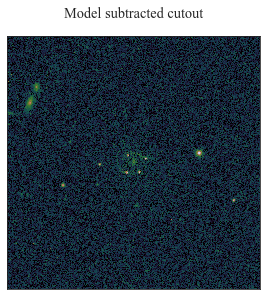

In [34]:
fig, ax = plt.subplots(figsize=pf.get_fig_size(width=2*pf.mnras_textwidth/3., height_ratio=1.))

ax.matshow(np.log10(np.abs(-model_image + large_image)), origin='lower', cmap=pf.cmap, 
           vmax=np.log10(np.abs(large_image)).max(), vmin=-3.)
ax.set_title('Model subtracted cutout')

ax.set_xticks([])
ax.set_yticks([]);


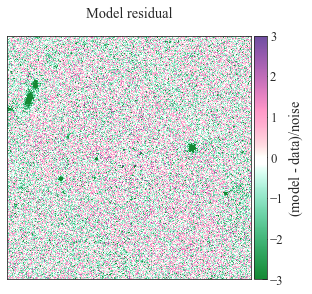

In [35]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


fig, ax = plt.subplots(figsize=pf.get_fig_size(width=2*pf.mnras_textwidth/3., height_ratio=1.))

noise = np.sqrt(np.abs(kwargs_data_large['image_data'] / kwargs_data_large['exposure_time']) + kwargs_data_large['background_rms']**2)

cbar = ax.matshow((model_image - large_image)/noise, origin='lower', cmap=msh_cmap2, vmax=3, vmin=-3)

ax.set_title('Model residual')

ax.set_xticks([])
ax.set_yticks([])

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(cbar, cax=cax, label=r'(model - data)$/$noise')

# plt.savefig('/Users/ajshajib/Dropbox/Papers_Proposals/2038_model/figures/large_coutout_model_residual.pdf', 
#             bbox_inches='tight')
plt.show()


### make figure for paper

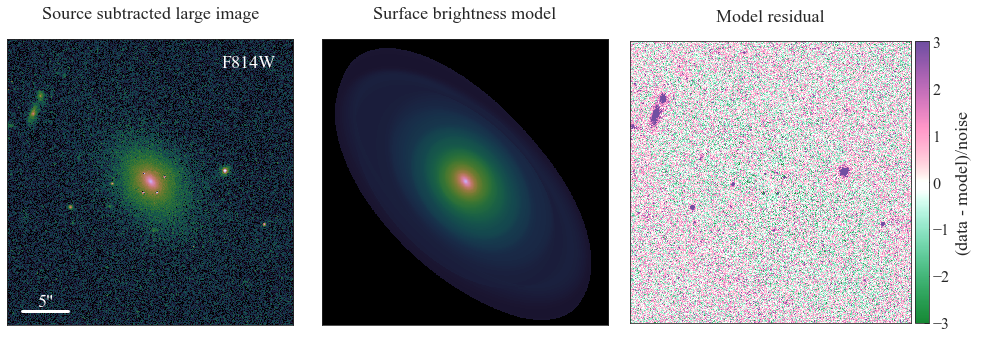

In [36]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


fig = plt.figure(figsize=pf.get_fig_size(width=2*pf.mnras_textwidth, height_ratio=1/3))

ax = fig.add_subplot(131)
ax.matshow(np.log10(np.abs(large_image)), origin='lower', cmap=pf.cmap, 
           vmax=np.log10(np.abs(large_image)).max(), vmin=-3.)
ax.set_title('Source subtracted large image', fontdict={'fontsize': pf.mnras_text_fontsize*2})

band_labels = ['F814W', 'F475X', 'F160W']
ax.text(0.75, 0.9, band_labels[band_index], color='white', fontdict={'fontsize': pf.mnras_text_fontsize*2},
        transform=ax.transAxes
       )

add_scale_bar(ax, length=5, fontsize=pf.mnras_text_fontsize*2, scale_text=None);
    
ax.set_xticks([])
ax.set_yticks([])
# plt.savefig('/Users/ajshajib/Dropbox/Papers_Proposals/2038_model/figures/source_subtracted_large_cutout.pdf', 
#             bbox_inches='tight')

ax = fig.add_subplot(132)

ax.matshow(np.log10(model_image+1e-3), origin='lower', cmap=pf.cmap, 
           vmax=np.log10(np.abs(large_image)).max(), vmin=-3.)

ax.set_title('Surface brightness model', fontdict={'fontsize': pf.mnras_text_fontsize*2})

ax.set_xticks([])
ax.set_yticks([])


ax = fig.add_subplot(133)

noise = np.sqrt(np.abs(kwargs_data_large['image_data'] / kwargs_data_large['exposure_time']) + kwargs_data_large['background_rms']**2)

cbar = ax.matshow((large_image - model_image)/noise, origin='lower', cmap=msh_cmap2, vmax=3, vmin=-3)

ax.set_title('Model residual', fontdict={'fontsize': pf.mnras_text_fontsize*2})

ax.set_xticks([])
ax.set_yticks([])

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

colorbar = plt.colorbar(cbar, cax=cax)
colorbar.set_label(label=r'(data - model)$/$noise', fontsize=pf.mnras_text_fontsize*2)
colorbar.ax.tick_params(labelsize=pf.mnras_figcaption_fontsize*2)

fig.tight_layout()

# fig.savefig('/Users/ajshajib/Dropbox/Papers_Proposals/2038_model/figures/large_cutout_model_f814w.pdf', 
#             bbox_inches='tight')

plt.show()


Text(0.5, 1.05, 'Inner region model')

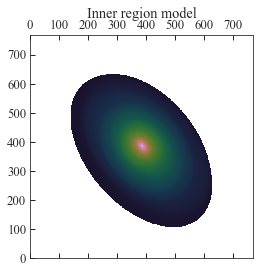

In [16]:
model_image = build_ellipse_model(large_image.shape, isolist)
#residual = data - model_image

plt.matshow(np.log10(model_image), origin='lower', cmap=pf.cmap, 
           vmax=np.log10(np.abs(large_image)).max(), vmin=-3.)
plt.title('Inner region model')

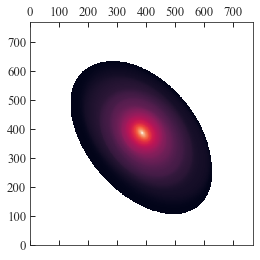

In [17]:
plt.matshow(np.log10(model_image), origin='lower')


### apparent magnitude by summing over the modelled flux

In [38]:
from astropy.io.fits import getheader

total_flux = np.sum(model_image)

data_total_eletrons = large_image_backup * wht_map
data_total_eletrons[data_total_eletrons < 0. ] = 0.

flux_noise = np.sqrt(data_total_eletrons/wht_map**2 + bkg_rms**2)
flux_noise[model_image <= 0] = 0.

total_flux_noise = np.sqrt(np.sum(flux_noise**2))

print(total_flux, total_flux_noise)

if band_index == 0:
    header = getheader('../data/reduced_data/DESJ2038-4008_F814W_drc_sci.fits')
elif band_index == 1:
    header = getheader('../data/reduced_data/DESJ2038-4008_F475X_drc_sci.fits')

photflam, photzpt, photplam =  header['PHOTFLAM'], header['PHOTZPT'], header['PHOTPLAM']


def get_stmag(electron_flux, photflam, photzpt):
    electron_flux = np.asarray(electron_flux)
    scalar_input = False
    if electron_flux.ndim == 0:
        electron_flux = electron_flux[None]  
        scalar_input = True

    flux = electron_flux * photflam
    mag = -2.5 * np.log10(flux) + photzpt

    if scalar_input:
        return np.squeeze(mag)

    return mag

def get_abmag(electron_flux, photflam, photzpt, photplam):
    stmag = get_stmag(electron_flux, photflam, photzpt)

    return stmag - 5. * np.log10(photplam) + 2.5 * np.log10(299792458e10) - 27.5

mag_distribution = get_abmag(np.random.normal(loc=total_flux, scale=total_flux_noise, size=1000), photflam, photzpt, photplam)

print(np.mean(mag_distribution), np.std(mag_distribution))

2628.888179802816 3.670229
16.59058615216861 0.0014599309418950736


F814W: 16.692415876617986 ± 0.0013693179022998786 #17.005958536074623 ± 0.0010978868335040292

F475X: 

In [39]:
from photutils.aperture import aperture_photometry
from photutils.aperture import CircularAperture, CircularAnnulus


aperture = CircularAperture([242.+96*1.5, 240+96*1.5], r=1.36/0.04)
phot_table = aperture_photometry(model_image, aperture)

phot_table[0]['aperture_sum']/total_flux

0.29062065662815506

In [19]:
from photutils.aperture import aperture_photometry
from photutils.aperture import CircularAperture, CircularAnnulus


aperture = CircularAperture([242.+96*1.5, 240+96*1.5], r=1.36/0.04)
phot_table = aperture_photometry(model_image, aperture)

phot_table[0]['aperture_sum']/total_flux

0.3276203396255546

### using aperture photometry functions from `astropy`

In [40]:
from astropy.stats import sigma_clipped_stats
from photutils.datasets import make_100gaussians_image

from photutils.utils import calc_total_error

effective_gain = wht_map  # seconds
error = calc_total_error(large_image_backup, bkg_rms, effective_gain)  

phot_table = aperture_photometry(large_image_backup, aperture, error=error)  

positions = [(385., 384.)] #[(242+96*1.5, 240+96*1.5)]
aperture = CircularAperture(positions, r=160.)

phot_table = aperture_photometry(large_image, aperture, error=error)

mag_distribution = get_abmag(np.random.normal(loc=phot_table[0]['aperture_sum'], 
                                              scale=phot_table[0]['aperture_sum_err'], 
                                              size=1000), photflam, photzpt, photplam)

print(np.mean(mag_distribution), np.std(mag_distribution))

16.85607252108309 0.001094119595085567


### Find half-light radius

In [41]:
from photutils import CircularAperture
from photutils import aperture_photometry

positions = [(385., 384.)] #[(242+96*1.5, 240+96*1.5)]


total_flux = np.sum(model_image)

for r in range(1, 200):
    aperture = CircularAperture(positions, r=r)

    phot_table = aperture_photometry(model_image, aperture)
    if phot_table[0]['aperture_sum'] >= total_flux/2.:
        break
print("Pixels:", r, ", Radius: ", r * 0.04, "arcsecond")

Pixels: 73 , Radius:  2.92 arcsecond


In [40]:
# total uncertainty on R_eff

np.sqrt((1/r)**2 + 0.02**2)

0.026034165586355514

In [22]:
total_flux

2330.6062746902858

## Fit MGE

Here we fit a MGE to the light model to use the MGE light profiles in the kinematic computation.

In [23]:
import mgefit
from mgefit.find_galaxy import find_galaxy
from mgefit.mge_fit_1d import mge_fit_1d
from mgefit.sectors_photometry import sectors_photometry
from mgefit.mge_fit_sectors import mge_fit_sectors
from mgefit.mge_print_contours import mge_print_contours
from mgefit.mge_fit_sectors_twist import mge_fit_sectors_twist
from mgefit.sectors_photometry_twist import sectors_photometry_twist
from mgefit.mge_print_contours_twist import mge_print_contours_twist


### fit Gaussians to the PSF 

In [24]:
mean_psf_profile = (np.sum(kwargs_psf['kernel_point_source'], axis=0) + np.sum(kwargs_psf['kernel_point_source'], axis=1))/2.

psf_size = len(mean_psf_profile)

one_sided_psf_profile = mean_psf_profile[:int((psf_size-1)/2)+1][::-1] + mean_psf_profile[-int((psf_size-1)/2)-1:]

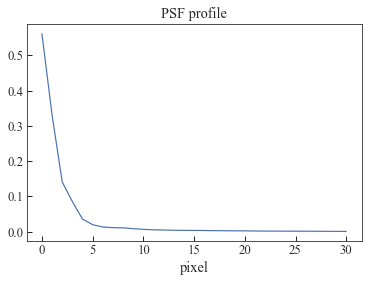

In [25]:
from scipy.interpolate import interp1d

n = 100  # number of sampled points
x = np.geomspace(0.01, 30, n)  # logarithmically spaced radii
y = interp1d(np.arange(len(one_sided_psf_profile)), one_sided_psf_profile)(x)  # The profile must be logarithmically sampled!
    
plt.plot(one_sided_psf_profile)
plt.title('PSF profile')
plt.xlabel('pixel')
plt.show()



Iteration: 1  chi2: 1.656 Nonzero: 8/9
Residuals > 10%: Change `inner_slope` or `outer_slope` or increase `ngauss`
Iteration: 8  chi2: 0.09407 Nonzero: 8/8
############################################
 Computation time: 0.04 seconds
 Total Iterations:  8
Nonzero Gaussians:  8
 Unused Gaussians:  1
 Chi2: 0.09407 
 STDEV: 0.03066
 MEANABSDEV: 0.01742
############################################
 Total_Counts      Sigma
############################################
  2.27482e-05   0.00707107
   0.00021622    0.0205547
   0.00178205    0.0605853
    0.0197296     0.185595
     0.479167     0.780876
      1.07746      1.83182
     0.220585      5.29539
     0.209773      16.6686
############################################


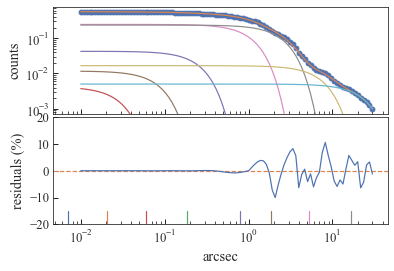

In [26]:
p = mge_fit_1d(x, y, plot=True, ngauss=9)

In [27]:
p.sol

array([[2.27482204e-05, 2.16220079e-04, 1.78205422e-03, 1.97296117e-02,
        4.79166925e-01, 1.07746167e+00, 2.20584933e-01, 2.09773118e-01],
       [7.07106781e-03, 2.05547233e-02, 6.05853140e-02, 1.85595182e-01,
        7.80876269e-01, 1.83182022e+00, 5.29538957e+00, 1.66685920e+01]])

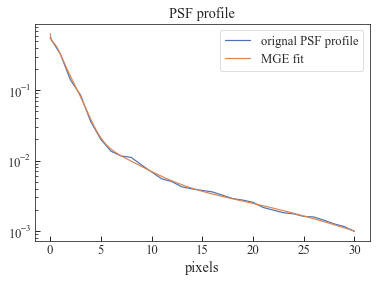

In [28]:
plt.plot(one_sided_psf_profile, label='orignal PSF profile')
plt.plot(p.x, np.sum(p.gauss*p.sol[0, :], axis=1), label='MGE fit')
plt.yscale('log')
plt.title('PSF profile')
plt.xlabel('pixels')
plt.legend()
plt.show()


### fit MGE to the galaxy model

 Pixels used: 176947
 Peak Img[j, k]: 384 384
 Mean (j, k): 379.54 386.54
 Theta (deg): 49.7
 Astro PA (deg): 40.3
 Eps: 0.354
 Major axis (pix): 311.4


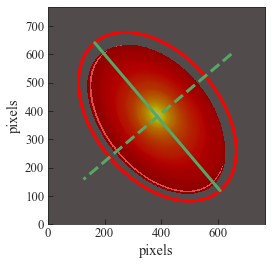

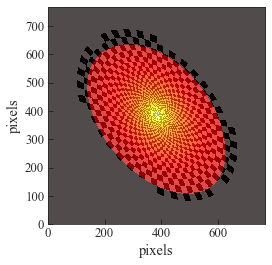

Iteration: 1  chi2: 115.4  Nonzero: 10/20
Iteration: 11  chi2: 107.2  Nonzero: 9/20
Iteration: 21  chi2: 95.1  Nonzero: 11/20
Nonzero Gaussians: 12/20
Eliminating not useful Gaussians...
ngauss: 11           chi2: 94.7
ngauss: 10           chi2: 94.7
ngauss: 9           chi2: 94.7
ngauss: 8           chi2: 94.8
ngauss: 7           chi2: 94.8
ngauss: 6           chi2: 95.3
Starting nonlinear fit...
Iteration: 1  chi2: 95.27  Nonzero: 6/6
Nonzero Gaussians: 6/6
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
 Computation time: 13.26 seconds
  Total Iterations:  23
 Nonzero Gaussians:  6
  Unused Gaussians:  14
 Sectors used in the fit:  19
 Total number of points fitted:  799
 Chi2: 94.78 
 STDEV: 0.3233 
 MEANABSDEV: 0.1714 
############################################
  Total_Counts  Sigma_Pixels      qObs
############################################
       21.293      2.38788     0.837776
      67.1612      6.13224     0.60602

Iteration: 11  chi2: 109.8  Nonzero: 9/20
Iteration: 21  chi2: 106.3  Nonzero: 11/20
Iteration: 31  chi2: 95.78  Nonzero: 10/20
Nonzero Gaussians: 10/20
Eliminating not useful Gaussians...
ngauss: 9           chi2: 94.7
ngauss: 8           chi2: 94.7
ngauss: 7           chi2: 94.8
ngauss: 6           chi2: 95.3
Starting nonlinear fit...
Iteration: 1  chi2: 95.29  Nonzero: 6/6
Nonzero Gaussians: 6/6
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
 Computation time: 18.37 seconds
  Total Iterations:  35
 Nonzero Gaussians:  6
  Unused Gaussians:  14
 Sectors used in the fit:  19
 Total number of points fitted:  799
 Chi2: 94.78 
 STDEV: 0.3233 
 MEANABSDEV: 0.1715 
############################################
  Total_Counts  Sigma_Pixels      qObs
############################################
      20.0224      2.32363     0.850841
      67.2388      6.01645     0.610065
       184.04      11.6084     0.587983
      376.157      2

Iteration: 11  chi2: 111.2  Nonzero: 8/20
Iteration: 21  chi2: 108.5  Nonzero: 9/20
Nonzero Gaussians: 9/20
Eliminating not useful Gaussians...
ngauss: 8           chi2: 102
ngauss: 7           chi2: 102
ngauss: 6           chi2: 102
Starting nonlinear fit...
Iteration: 1  chi2: 102.5  Nonzero: 6/6
Nonzero Gaussians: 6/6
Eliminating not useful Gaussians...
All Gaussians are needed!
############################################
 Computation time: 17.10 seconds
  Total Iterations:  30
 Nonzero Gaussians:  6
  Unused Gaussians:  14
 Sectors used in the fit:  19
 Total number of points fitted:  799
 Chi2: 102.2 
 STDEV: 0.334 
 MEANABSDEV: 0.1801 
############################################
  Total_Counts  Sigma_Pixels      qObs
############################################
      28.8553      2.69068     0.771553
      136.501      7.90084     0.609904
      165.794      16.0232     0.560951
      326.276      21.4127     0.882526
      471.534      57.9056          0.9
      809.667      8

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


############################################
Final Regularized MGE Solution:
  Total_Counts  Sigma_Pixels      qObs
############################################
      28.8553      2.69068     0.771553
      136.501      7.90084     0.609904
      165.794      16.0232     0.560951
      326.276      21.4127     0.882526
      471.534      57.9056          0.9
      809.667      83.0295         0.55
++++++++++++++++++++++++++++++++++++++++++++
Final qbounds=0.5500 0.9000
############################################


Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a 

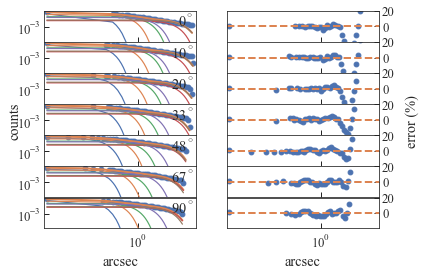

In [31]:
from mgefit.mge_fit_sectors_regularized import mge_fit_sectors_regularized

img = model_image

scale = 0.04  # arcsec/pixel
minlevel = 0.0  # counts/pixel
ngauss = 20

sigmapsf = p.sol[:, 1]      # In pixels
normpsf = p.sol[:, 0] / np.sum(p.sol[:, 0])  # total(normpsf)=1


# Here we use FIND_GALAXY directly inside the procedure. Usually you may want
# to experiment with different values of the FRACTION keyword, before adopting
# given values of Eps, Ang, Xc, Yc.
plt.clf()
f = find_galaxy(img, fraction=0.3, plot=1)
plt.show()

# Perform galaxy photometry
plt.clf()
s = sectors_photometry(img, f.eps, f.theta, f.xpeak, f.ypeak,
                       minlevel=minlevel, plot=1)
plt.show()

# Do the actual MGE fit
# *********************** IMPORTANT ***********************************
# For the final publication-quality MGE fit one should include the line
# "from mge_fit_sectors_regularized import mge_fit_sectors_regularized"
# at the top of this file, rename mge_fit_sectors() into
# mge_fit_sectors_regularized() and re-run the procedure.
# See the documentation of mge_fit_sectors_regularized for details.
# *********************************************************************
plt.clf()
m = mge_fit_sectors_regularized(s.radius, s.angle, s.counts, f.eps,
                    ngauss=ngauss, sigmapsf=sigmapsf, normpsf=normpsf,
                    scale=scale, plot=1, bulge_disk=0, linear=0)
plt.show()

(13.0, 18.0)

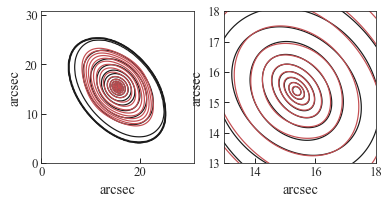

In [32]:
# Show contour plots of the results
plt.clf()
plt.subplot(121)
mge_print_contours(img.clip(minlevel), f.theta, f.xpeak, f.ypeak, m.sol, scale=scale,
                   binning=7, sigmapsf=sigmapsf, normpsf=normpsf, magrange=9)

# Extract the central part of the image to plot at high resolution.
# The MGE is centered to fractional pixel accuracy to ease visual comparison.

n = 10
img_clipped = img[f.xpeak-n:f.xpeak+n, f.ypeak-n:f.ypeak+n]
xc, yc = n - f.xpeak + f.xmed, n - f.ypeak + f.ymed
plt.subplot(122)
#mge_print_contours(img_clipped.clip(minlevel), f.theta, xc, yc, m.sol, binning=0.2,
#                  sigmapsf=sigmapsf, normpsf=normpsf, scale=scale)
mge_print_contours(img.clip(minlevel), f.theta, f.xpeak, f.ypeak, m.sol, scale=scale,
                   binning=1, sigmapsf=sigmapsf, normpsf=normpsf, magrange=9)
plt.xlim(13, 18)
plt.ylim(13, 18)

In [ ]:
python3 submit_idre.py 2038_run145_0_0_0_0_0_shortened powerlaw 1000
python3 submit_idre.py 2038_run145_0_0_1_0_0_shortened powerlaw 1000
python3 submit_idre.py 2038_run145_0_0_2_0_0_shortened powerlaw 1000
python3 submit_idre.py 2038_run145_0_1_0_0_0_shortened powerlaw 1000
python3 submit_idre.py 2038_run145_0_1_1_0_0_shortened powerlaw 1000
python3 submit_idre.py 2038_run145_0_1_2_0_0_shortened powerlaw 1000

python3 submit_idre.py 2038_run146_0_0_0_0_0_shortened powerlaw 1000
python3 submit_idre.py 2038_run146_0_0_1_0_0_shortened powerlaw 1000
python3 submit_idre.py 2038_run146_0_0_2_0_0_shortened powerlaw 1000
python3 submit_idre.py 2038_run146_0_1_0_0_0_shortened powerlaw 1000
python3 submit_idre.py 2038_run146_0_1_1_0_0_shortened powerlaw 1000
python3 submit_idre.py 2038_run146_0_1_2_0_0_shortened powerlaw 1000

In [33]:
sigmas = m.sol[1, :] * np.sqrt(1 - f.eps) * scale
amps = m.sol[0, :]

In [34]:
amps, sigmas

(array([ 28.8552871 , 136.50077782, 165.79432709, 326.27644665,
        471.53423998, 809.66654098]),
 array([0.08652982, 0.25408345, 0.51528969, 0.68861029, 1.86218783,
        2.67014751]))

### Plot the MGE profile and compare with the isophote-based model

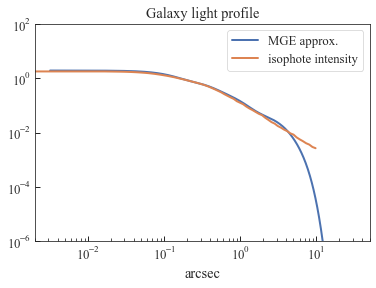

In [35]:
#plt.plot(m.radius * scale, np.sum(m.gauss*m.sol[0, :], axis=1), label='MGE fit', ls='none', marker='o')

xs = np.logspace(-2.5, 1.5, 1000)

mge_profile = 0
for a, s in zip(amps, sigmas):
    mge_profile += a / (2*np.pi) / s**2 * np.exp(-xs**2/2./s**2) * 0.04**2

#amp = interp1d(xs, mge_profile)(1.68) * (2*np.pi)

plt.plot(xs, mge_profile, label='MGE approx.', lw=2)
plt.plot(isolist.to_table()['sma'] * 0.04 * np.sqrt(1 - f.eps), 
         isolist.to_table()['intens'], label='isophote intensity', lw=2)
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-6, 1e2)
plt.title('Galaxy light profile')
plt.xlabel('arcsec')
plt.legend()
plt.show()


In [36]:

np.array(isolist.to_table()['sma'] * np.sqrt(1 - isolist.to_table()['ellipticity']))

array([  0.        ,   0.47718996,   0.52280133,   0.56989317,
         0.62034569,   0.67402225,   0.73132432,   0.79675577,
         0.8747291 ,   0.96780122,   1.06398574,   1.17537148,
         1.30433702,   1.44109608,   1.58133478,   1.74228904,
         1.9196295 ,   2.1160902 ,   2.33219053,   2.55522806,
         2.79274277,   3.05357664,   3.32835115,   3.61787684,
         3.93499407,   4.28427794,   4.65279936,   5.05429746,
         5.49833559,   5.97583317,   6.4756971 ,   7.02021247,
         7.62875393,   8.36313655,   9.20568151,  10.16372937,
        11.18963247,  12.4352782 ,  13.70118295,  15.36512676,
        17.03640153,  18.74352729,  20.61788002,  23.28594164,
        25.92322048,  28.51554253,  32.19483637,  36.19779783,
        40.20734773,  44.45862682,  48.2259701 ,  52.49511783,
        58.96469005,  66.11840156,  72.00043718,  77.19629571,
        84.49442722,  91.11096542, 100.22206196, 108.17877737,
       119.59054105, 127.87230524, 144.61738544, 155.57

In [42]:
from fastell4py import fastell4py

In [43]:
fastell4py.__file__

'/Users/ajshajib/.local/lib/python3.7/site-packages/fastell4py-0.1.0-py3.7-macosx-10.9-x86_64.egg/fastell4py/fastell4py.py'

In [44]:
fastell4py.fastelldefl()

TypeError: fastelldefl() missing 6 required positional arguments: 'x1', 'x2', 'q', 'gam', 'arat', and 's2'

In [47]:
fastell4py.__author__

AttributeError: module 'fastell4py.fastell4py' has no attribute '__author__'